In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from numpy.ma import masked_array
from statsmodels.stats.multitest import multipletests

# Load data 

In [2]:
path_root = '/home/kmb/Desktop/Neuroscience/Projects/FINC_learning_brain/data/derivatives/mlm_networks_summary'

# 'normalized' or 'raw'
dataset = 'normalized'
# 'power' or 'schaefer'
atlas = 'power'

In [3]:
path_stats = f'whole-brain_{atlas}_{dataset}_mlm_stats.csv'
path_params = f'whole-brain_{atlas}_{dataset}_mlm_params.csv'

df_stats = pd.read_csv(os.path.join(path_root, path_stats), index_col=0)
df_params = pd.read_csv(os.path.join(path_root, path_params), index_col=0)

if atlas == 'power':
    labels = ['AU', 'CER', 'CO', 'DA', 'DM', 'FP', 'MEM', 
              'SAL', 'SOM', 'SUB', 'UNC', 'VA', 'VIS']
else:
    labels = ['CON', 'DA', 'DM', 'LIM', 'SAL', 'SOM', 'VIS']

n_lsn = len(labels)

Change data format. Split data into set of upper-triangular arrays of size $13 \times 13$.

#### Multi-level modeling (MLM) comparison arrays 

Represents results of statistical model comparison. First index is coding different models (0: group model; 1: session model; 2: interaction model) while next indices are coding LSNs:

- `chi_mlm`: $\chi^2$ test value for single model evaluation
- `pval_mlm`: corresponding $p$ values 

#### Estimated model parameter arrays

Respresents estimated influence of different dependent variables on independent variable (here recruitment or integration). First index is coding different session pairs (0: Naive vs Early; 1: Naive vs Middle; 2: Naive vs Late) while next indices are coding LSN group assignment:

- `beta_ses`: linear regression $\beta$ parameters for session model
- `beta_inter`: linear regression $\beta$ parameters for interaction model

In [4]:
chi_mlm = np.zeros((3, n_lsn, n_lsn))
pval_mlm = np.zeros((3, n_lsn, n_lsn))

for idx, row in df_stats.iterrows():
    
    i, j = int(row.i) - 1, int(row.j) - 1
    
    chi_mlm[0, i, j] = row.chi_group
    chi_mlm[1, i, j] = row.chi_session
    chi_mlm[2, i, j] = row.chi_interaction

    pval_mlm[0, i, j] = row.pval_group
    pval_mlm[1, i, j] = row.pval_session
    pval_mlm[2, i, j] = row.pval_interaction
    
beta_ses = np.zeros((3, n_lsn, n_lsn))
beta_inter = np.zeros((3, n_lsn, n_lsn))

for idx, row in df_params.iterrows():
    
    i, j = int(row.i) - 1, int(row.j) - 1
    
    for ses in range(3):
        beta_ses[ses, i, j] = row[f'beta1{ses+2}_session']
        beta_inter[ses, i, j] = row[f'beta1{ses+2}_interaction']

In [5]:
def correct_pvals_array(pvals, method='fdr_bh'):
    ''' Perform multiple comparison correction on p-values arranged into square
    array. 
    
    Args:
        pvals (array_like): 
            Upper-triangular array of p-values.
        method (str):
            Correction method passed to multipletests function from statsmodels
            library.
            
    Returns
        (array_like): Corrected p-vales. Same dimension as input array.
    '''

    upper_ind = np.triu_indices(pvals.shape[0], k=0)
    pvals_vec = pvals[upper_ind]

    pvals_vec_corrected = multipletests(
        pvals_vec,
        alpha=0.05,
        method=method,
        is_sorted=False,
        returnsorted=False,
        )[1]

    pvals_corrected = np.zeros(pvals.shape)
    pvals_corrected[upper_ind] = pvals_vec_corrected
    return pvals_corrected

symmetrize = lambda x: x + x.T - np.diag(np.diag(x))

# Manage plt.rc settings

In [6]:
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15) 
plt.rc('figure', figsize=(10, 10))

cbar_width = 0.03
cbar_offset = 0.02

# Create custom colormap (diverging black - white - black)
col_gray = (.75, .75, .75)
col_white = (1, 1, 1)
newcmp = LinearSegmentedColormap.from_list(
    'gray_div', 
    [col_gray, col_white, col_gray], 
    N=128)

# Generate figures

#### Figure 1.
Significant effects for group model (FDR corrected; p<0.05). Colored tiles represent significant effect. Color is coding estimated $\beta$ parameter for change between Naive and Late stage.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


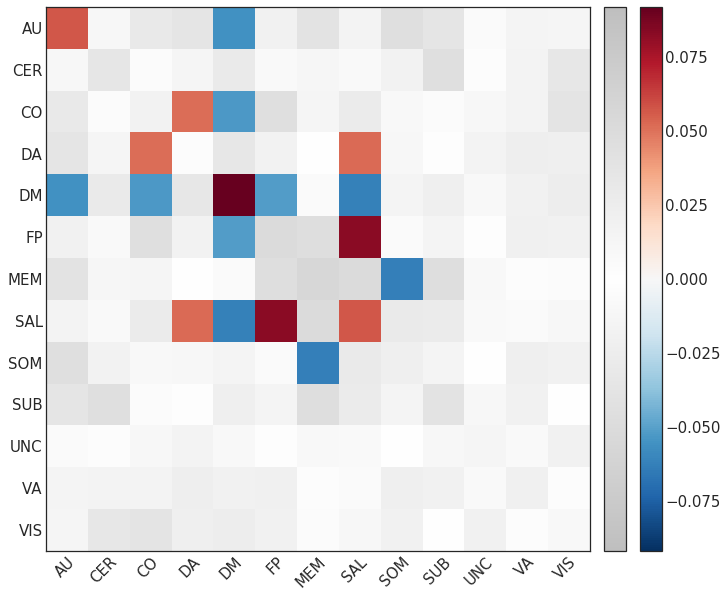

In [7]:
# Data to be plotted
pval_session_corrected = symmetrize(correct_pvals_array(pval_mlm[1]))
beta_sig = masked_array(symmetrize(beta_ses[-1]), pval_session_corrected > .05)
beta_nsig = masked_array(symmetrize(beta_ses[-1]), pval_session_corrected <= .05)

fig, ax = plt.subplots(facecolor='w')

# Manage labels
ax.set_xticks(np.arange(n_lsn))
ax.set_yticks(np.arange(n_lsn))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Plot heatmaps
clim = [-np.max(np.abs(beta_sig)), np.max(np.abs(beta_sig))]
im_sig = ax.imshow(beta_sig, cmap='RdBu_r', clim=clim)
im_nsig = ax.imshow(beta_nsig, cmap=newcmp, clim=clim)

# Create colorbars
cb_sig_axes = fig.add_axes([ax.get_position().x1 + cbar_offset * 2 + cbar_width, 
                            ax.get_position().y0, 
                            cbar_width,
                            ax.get_position().height])
cb_nsig_axes = fig.add_axes([ax.get_position().x1 + cbar_offset, 
                             ax.get_position().y0, 
                             cbar_width, 
                             ax.get_position().height])

cb_sig = plt.colorbar(im_sig, cax=cb_sig_axes)
cb_nsig = plt.colorbar(im_nsig, cax=cb_nsig_axes)
cb_nsig.set_ticks([])

#### Figure 2.
Significant effects for interaction model (**uncorrected**; p<0.05). Colored tiles represent significant effect. Color is coding estimated $\beta$ parameter for change between Naive and Late stage.

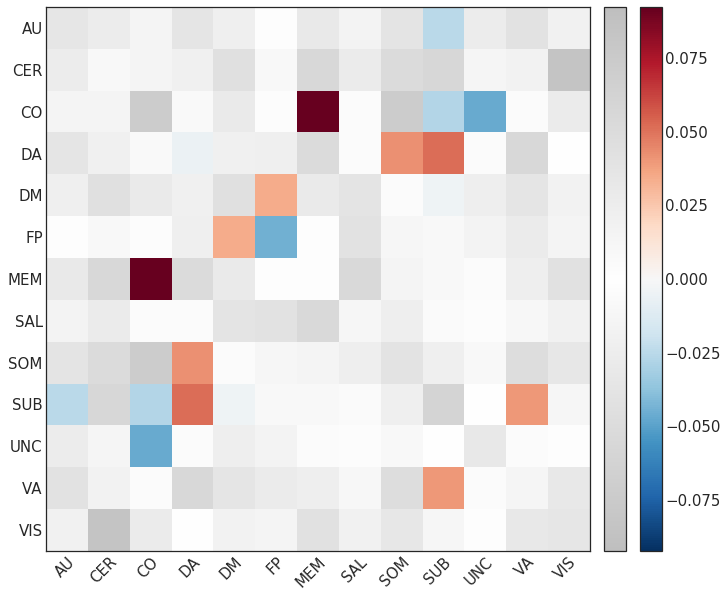

In [8]:
# Data to be plotted
pval_session_corrected = symmetrize(pval_mlm[2])
beta_sig = masked_array(symmetrize(beta_inter[-1]), pval_session_corrected > .05)
beta_nsig = masked_array(symmetrize(beta_inter[-1]), pval_session_corrected <= .05)

fig, ax = plt.subplots(facecolor='w')

# Manage labels
ax.set_xticks(np.arange(n_lsn))
ax.set_yticks(np.arange(n_lsn))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Plot heatmaps
clim = [-np.max(np.abs(beta_sig)), np.max(np.abs(beta_sig))]
im_sig = ax.imshow(beta_sig, cmap='RdBu_r', clim=clim)
im_nsig = ax.imshow(beta_nsig, cmap=newcmp, clim=clim)

# Create colorbars
cb_sig_axes = fig.add_axes([ax.get_position().x1 + cbar_offset * 2 + cbar_width, 
                            ax.get_position().y0, 
                            cbar_width,
                            ax.get_position().height])
cb_nsig_axes = fig.add_axes([ax.get_position().x1 + cbar_offset, 
                             ax.get_position().y0, 
                             cbar_width, 
                             ax.get_position().height])

cb_sig = plt.colorbar(im_sig, cax=cb_sig_axes)
cb_nsig = plt.colorbar(im_nsig, cax=cb_nsig_axes)
cb_nsig.set_ticks([])